# Atividade 8 - Classificador Redes Neurais

# Branch and Bound - Sem Normalização

# Algoritmo Redes Neurais

Redes Neurais:

● Realizar validação cruzada k=10 para testar Redes Neurais utilizando:
    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)

Em cada um, calibrar os parâmetros (funcao de ativacao da camada escondida, parâmetros de regularizaçao e quantidade de neuronios e a função de saida softmax) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.neural_network import MLPClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Branch and Bound na atividade 4

In [3]:
selecionadas_BB = ['Age','Number of sexual partners',
                   'First sexual intercourse', 'Num of pregnancies',
                   'Smokes (years)','Smokes']


## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [6]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')

    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))

    
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    hidden_layers = grid_params.get('hidden_layer_sizes')
    alpha_step = grid_params.get('alpha_step')
    activation = grid_params.get('activation')
    
    
    # Testa varios KERNELS
    for act in activation:
        print("-> Teste Funcao de Ativacao da camada oculta {}".format(act))
        
        for hidden in hidden_layers:
            print("-> Quantidade de neuronios {}".format(hidden))
 
            alphaX = 0.01
            while alphaX <= 0.1:
                print("-> Valor alpha{}".format(alphaX))
                
                print('-> Criando modelo com params hidden={}, act={}, alpha={}'.format(hidden, act, alphaX))
                clf = algoritmo(hidden_layer_sizes=(hidden, ), activation=act, verbose = 1, solver='lbfgs', alpha=alphaX)
                clf.out_activation_ = 'softmax'
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))  
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)
                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                            % (y_test.shape[0], (y_test != y_pred).sum()))
                    # print("Number of points predicted as Pos: %d"
                    #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([act, hidden, alphaX, fold_number, precision, recall, accuracy])
                        
                alphaX = alphaX + 0.01
                
        
    return np.array(scores)

In [10]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')

    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))

        # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)
    
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    hidden_layers = grid_params.get('hidden_layer_sizes')
    alpha_step = grid_params.get('alpha_step')
    activation = grid_params.get('activation')
    
    
    # Testa varios KERNELS
    for act in activation:
        print("-> Teste Funcao de Ativacao da camada oculta: {}".format(act))
        
        for hidden in hidden_layers:
            print("-> Quantidade de neuronios: {}".format(hidden))
 
            alphaX = 0.01
            while alphaX <= 0.1:
                print("-> Valor alpha: {}".format(alphaX))
                
                print('-> Criando modelo com params hidden={}, act={}, alpha={}'.format(hidden, act, alphaX))
                clf = algoritmo(hidden_layer_sizes=(hidden, ), activation=act, verbose = 1, solver='lbfgs', alpha=alphaX)
                clf.out_activation_ = 'softmax'
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))  
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)
                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                            % (y_test.shape[0], (y_test != y_pred).sum()))
                    # print("Number of points predicted as Pos: %d"
                    #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    print('Recall')
                    print(recall)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([act, hidden, alphaX, fold_number, precision, recall, accuracy])
                        
                alphaX = alphaX + 0.01
                
        
    return np.array(scores)

### Dataset Balanceado

## Grid de Parametros para teste

In [11]:
grid_params_all = {'hidden_layer_sizes': [10, 7, 70],
                   'alpha_step': 0.01,
                   'activation': ['tanh', 'relu']
                  }

#grid_params_semi = {'gamma_range': [1e-4, 10e-1],
#               'gamma_step': 0.01,
#               'kernels': ['linear', 'rbf', 'sigmoid'],#, 'precomputed'],
#               'C_range': [1, 10, 100, 1000]
#              }

#grid_params_semi = {'hidden_layer_sizes': [10, 7, 70],
#                    'alpha_step': 0.01,
#                    'activation': ['tanh', 'relu']
#                   }

#grid_params_linear = {'kernels': ['linear'],
#                      'C_range': [1, 10, 100, 1000]
#                     }


#grid_params_tanh = {'hidden_layer_sizes': [10, 7, 70],
#                       'alpha_step': 0.001,
#                       'activation': ['tanh'],
#                       'solver': ['lbfgs', 'sgd', 'adam']
#                      }


#grid_params_relu= {'hidden_layer_sizes': [10, 7, 70],
#                   'alpha_step': 0.001,
#                   'activation': ['relu'],
#                   'solver': ['lbfgs', 'sgd', 'adam']
#                   }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> Redes Neurais

In [12]:
df_selecionado = df_imp[selecionadas_BB]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes (years),Smokes,Biopsy
0,18.0,4.0,15.0,1.0,0.0,0.0,0
1,15.0,1.0,14.0,1.0,0.0,0.0,0
2,34.0,1.0,17.0,1.0,0.0,0.0,0
3,52.0,5.0,16.0,4.0,37.0,1.0,0
4,46.0,3.0,21.0,4.0,0.0,0.0,0


### Dataset Desbalanceado

Atenção:

Durante o treinamento, por conta do Verbose=1, o algoritmo de otimização detectou que, com alta probabilidade seria possivel acelerar o treinamento colocando -h 0 nos parametros. 

Basicamente, -h é a heurística cada vez menor, implementada no pacote libsvm que, para alguns dados, reduz significativamente o número de computações necessárias, enquanto em outras, o torna mais lento

A mensagem que foi exibida foi: "Warning: using -h 0 may be faster"

-h == parametro shrinking do SVC

Por isso esse parametro é passado a função de cross validation como FALSE (default é True)

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=False))

#scores.append([act, hidden, alpha, fold_number, precision, recall, accuracy])
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'FUNATIVACAO', 1: 'QTDCAMADA', 2: 'Alpha', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['Alpha', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Funcao de Ativacao da camada oculta tanh
-> Quantidade de neuronios 10
-> Valor alpha0.01
-> Criando modelo com params hidden=10, act=tanh, alpha=0.01
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do to

	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Valor alpha0.07
-> Criando modelo com params hidden=10, act=tanh, alpha=0.07
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Tota

	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.03
-> Criando modelo com params hidden=7, act=tanh, alpha=0.03
Fold 1: Pos: 5, Neg: 81, Total

	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do t

	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Valor alpha0.04
-> Criando modelo com params hidden=70, act=tanh, alpha=0.04
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Tota

	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Valor alpha0.09999999999999999
-> Criando modelo com params hidden=70, act=tanh, alpha=0.09999999999999999
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 9

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 78
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 37
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do 

	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.08
-> Criando modelo com params hidden=7, act=relu, alpha=0.08
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 81
Fold 2: Pos: 5, Neg: 81, Tota

	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.04
-> Criando modelo com params hidden=70, act=relu, alpha=0.04
Fold 1: Pos: 5, Neg: 81, Tota

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do t

In [14]:
display(scores_unbalanced.head(20))

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Branch_and_Bound-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,FUNATIVACAO,QTDCAMADA,Alpha,Fold,Precision,Recall,Accuracy,Algorimto
0,tanh,10,0.01,1,0.0,0.0,0.941860,MLPClassifier
1,tanh,10,0.01,2,0.0,0.0,0.941860,MLPClassifier
2,tanh,10,0.01,3,0.0,0.0,0.941860,MLPClassifier
3,tanh,10,0.01,4,0.0,0.0,0.918605,MLPClassifier
4,tanh,10,0.01,5,0.0,0.0,0.930233,MLPClassifier
5,tanh,10,0.01,6,0.0,0.0,0.930233,MLPClassifier
6,tanh,10,0.01,7,0.0,0.0,0.930233,MLPClassifier
7,tanh,10,0.01,8,0.0,0.0,0.883721,MLPClassifier
8,tanh,10,0.01,9,0.0,0.0,0.941176,MLPClassifier
9,tanh,10,0.01,10,0.0,0.0,0.929412,MLPClassifier


### Dataset Balanceado

In [15]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=False))

#scores.append([act, hidden, alpha, fold_number, precision, recall, accuracy])
scores_balanced = scores_balanced.rename(columns = {0: 'FUNATIVACAO', 1: 'QTDCAMADA', 2: 'Alpha', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'MLPClassifier'
float_cols = ['Alpha', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Funcao de Ativacao da camada oculta: tanh
-> Quantidade de neuronios: 10
-> Valor alpha: 0.01
-> Criando modelo com params hidden=10, act=tanh, alpha=0.01
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.16666666666666666
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.2
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.16666666666666666
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, N

	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 10
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
-> Valor alpha: 0.02
-> Criando modelo com params hidden=7, act=tanh, alpha=0.02
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 10
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificada

	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 6
Recall
0.0
-> Valor alpha: 0.07
-> Criando modelo com params hidden=7, act=tanh, alpha=0.07
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.2
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas 

	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.16666666666666666
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, N

	Numero de instancias classificadas erradas do total de 86 instancias : 8
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 8
Recall
0.0
-> Valor alpha: 0.08
-> Criando 

	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
-> Valor alpha: 0.03
-> Criando modelo com params hidden=10, act=relu, alpha=0.03
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
-> Valor alpha: 0.04
-> Criando modelo com params hidden=7, act=relu, alpha=0.04
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, 

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 8

	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 10
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
-> Valor alpha: 0.05
-> Criando modelo com params hidden=70, act=relu, alpha=0.05
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificada

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 8

In [16]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Branch_and_Bound-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,FUNATIVACAO,QTDCAMADA,Alpha,Fold,Precision,Recall,Accuracy,Algorimto
0,tanh,10,0.01,1,0.000000,0.000000,0.941860,MLPClassifier
1,tanh,10,0.01,2,0.000000,0.000000,0.941860,MLPClassifier
2,tanh,10,0.01,3,0.000000,0.000000,0.941860,MLPClassifier
3,tanh,10,0.01,4,0.333333,0.166667,0.918605,MLPClassifier
4,tanh,10,0.01,5,0.000000,0.000000,0.930233,MLPClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [17]:
mean_unbalanced = scores_unbalanced.groupby(['FUNATIVACAO','QTDCAMADA','Alpha']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                               
relu        10        0.01    0.007595  0.100000  0.858003
                      0.02    0.050000  0.020000  0.935910
                      0.03    0.000000  0.000000  0.934747
                      0.04    0.000000  0.000000  0.935910
                      0.05    0.007143  0.100000  0.851026
                      0.06    0.000000  0.000000  0.935910
                      0.07    0.000000  0.000000  0.935910
                      0.08    0.000000  0.000000  0.935910
                      0.09    0.000000  0.000000  0.931259
                      0.10    0.000000  0.000000  0.933584
            7         0.01    0.010256  0.066667  0.899863
                      0.02    0.000000  0.000000  0.934747
                      0.03    0.000000  0.000000  0.935910
                      0.04    0.000000  0.000000  0.935910
                      0.05    0.000000  0.000000  0.935910
                      0.06    0.000000  0.000000  0.934733
                      0.07    0.000000  0.000000  0.934747
                      0.08    0.055814  0.140000  0.847538
                      0.09    0.000000  0.000000  0.934747
                      0.10    0.000000  0.000000  0.930096
            70        0.01    0.000000  0.000000  0.933570
                      0.02    0.000000  0.000000  0.935910
                      0.03    0.000000  0.000000  0.934747
                      0.04    0.000000  0.000000  0.934747
                      0.05    0.000000  0.000000  0.935910
                      0.06    0.000000  0.000000  0.934733
                      0.07    0.000000  0.000000  0.935910
                      0.08    0.000000  0.000000  0.935910
                      0.09    0.000000  0.000000  0.933584
                      0.10    0.000000  0.000000  0.934747
tanh        10        0.01    0.000000  0.000000  0.928919
                      0.02    0.100000  0.020000  0.927770
                      0.03    0.000000  0.000000  0.927770
                      0.04    0.000000  0.000000  0.933570
                      0.05    0.000000  0.000000  0.933570
                      0.06    0.000000  0.000000  0.927743
                      0.07    0.000000  0.000000  0.934733
                      0.08    0.050000  0.020000  0.934747
                      0.09    0.000000  0.000000  0.933570
                      0.10    0.000000  0.000000  0.928919
            7         0.01    0.000000  0.000000  0.928919
                      0.02    0.000000  0.000000  0.934747
                      0.03    0.000000  0.000000  0.934733
                      0.04    0.000000  0.000000  0.927770
                      0.05    0.000000  0.000000  0.934747
                      0.06    0.000000  0.000000  0.934747
                      0.07    0.000000  0.000000  0.930096
                      0.08    0.000000  0.000000  0.932408
                      0.09    0.000000  0.000000  0.930068
                      0.10    0.000000  0.000000  0.933584
            70        0.01    0.000000  0.000000  0.921929
                      0.02    0.000000  0.000000  0.920780
                      0.03    0.000000  0.000000  0.918427
                      0.04    0.000000  0.000000  0.924241
                      0.05    0.000000  0.000000  0.919590
                      0.06    0.000000  0.000000  0.923092
                      0.07    0.000000  0.000000  0.920739
                      0.08    0.000000  0.000000  0.923105
                      0.09    0.000000  0.000000  0.919603
                      0.10    0.000000  0.000000  0.924241

In [18]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision  Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                             
relu        70        0.02        0.00    0.00   0.93591
            7         0.04        0.00    0.00   0.93591
            10        0.04        0.00    0.00   0.93591
                      0.02        0.05    0.02   0.93591
                      0.06        0.00    0.00   0.93591

('relu', '10', 0.02)

### Dataset Balanceado

In [19]:
mean_balanced = scores_balanced.groupby(['FUNATIVACAO','QTDCAMADA','Alpha']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                               
relu        10        0.01    0.000000  0.000000  0.935910
                      0.02    0.000000  0.000000  0.934747
                      0.03    0.000000  0.000000  0.934747
                      0.04    0.000000  0.000000  0.931259
                      0.05    0.000000  0.000000  0.934747
                      0.06    0.000000  0.000000  0.935910
                      0.07    0.000000  0.000000  0.934747
                      0.08    0.000000  0.000000  0.935910
                      0.09    0.000000  0.000000  0.934747
                      0.10    0.000000  0.000000  0.935910
            7         0.01    0.013469  0.200000  0.771956
                      0.02    0.000000  0.000000  0.930096
                      0.03    0.000000  0.000000  0.935910
                      0.04    0.000000  0.000000  0.934747
                      0.05    0.000000  0.000000  0.935910
                      0.06    0.006977  0.100000  0.849863
                      0.07    0.000000  0.000000  0.924213
                      0.08    0.000000  0.000000  0.935910
                      0.09    0.005814  0.100000  0.846375
                      0.10    0.000000  0.000000  0.932421
            70        0.01    0.000000  0.000000  0.934747
                      0.02    0.050000  0.020000  0.935910
                      0.03    0.020000  0.020000  0.931259
                      0.04    0.000000  0.000000  0.931259
                      0.05    0.000000  0.000000  0.935910
                      0.06    0.000000  0.000000  0.933584
                      0.07    0.000000  0.000000  0.931259
                      0.08    0.000000  0.000000  0.934747
                      0.09    0.000000  0.000000  0.934747
                      0.10    0.000000  0.000000  0.935910
tanh        10        0.01    0.033333  0.016667  0.933570
                      0.02    0.000000  0.000000  0.931231
                      0.03    0.000000  0.000000  0.934747
                      0.04    0.000000  0.000000  0.928919
                      0.05    0.000000  0.000000  0.928892
                      0.06    0.150000  0.036667  0.930082
                      0.07    0.000000  0.000000  0.932394
                      0.08    0.000000  0.000000  0.930082
                      0.09    0.000000  0.000000  0.931259
                      0.10    0.033333  0.020000  0.931245
            7         0.01    0.000000  0.000000  0.931259
                      0.02    0.000000  0.000000  0.930096
                      0.03    0.000000  0.000000  0.935910
                      0.04    0.000000  0.000000  0.933584
                      0.05    0.000000  0.000000  0.934747
                      0.06    0.000000  0.000000  0.930082
                      0.07    0.050000  0.020000  0.934747
                      0.08    0.000000  0.000000  0.932421
                      0.09    0.000000  0.000000  0.934747
                      0.10    0.000000  0.000000  0.932408
            70        0.01    0.000000  0.000000  0.921929
                      0.02    0.033333  0.016667  0.921902
                      0.03    0.000000  0.000000  0.921943
                      0.04    0.050000  0.020000  0.930096
                      0.05    0.025000  0.016667  0.926594
                      0.06    0.000000  0.000000  0.921902
                      0.07    0.000000  0.000000  0.924241
                      0.08    0.000000  0.000000  0.925417
                      0.09    0.000000  0.000000  0.923092
                      0.10    0.033333  0.020000  0.924254

In [20]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision  Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                             
relu        10        0.01         0.0     0.0   0.93591
tanh        7         0.03         0.0     0.0   0.93591
relu        70        0.05         0.0     0.0   0.93591
                      0.10         0.0     0.0   0.93591
            10        0.06         0.0     0.0   0.93591

('relu', '10', 0.01)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [21]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['FUNATIVACAO'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['QTDCAMADA'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['Alpha'] == max_alpha_unbalanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.936, IC = [0.932, 0.940]
Recall: Média = 0.020, IC = [-0.025, 0.065]
Precisão: Média = 0.050, IC = [-0.063, 0.163]


### Dataset Balanceado

In [22]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['FUNATIVACAO'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['QTDCAMADA'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['Alpha'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.936, IC = [0.932, 0.940]
Recall: Média = 0.000, IC = [nan, nan]
Precisão: Média = 0.000, IC = [nan, nan]


## Gráfico

In [23]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(157.00000000000003, 0.5, '')]

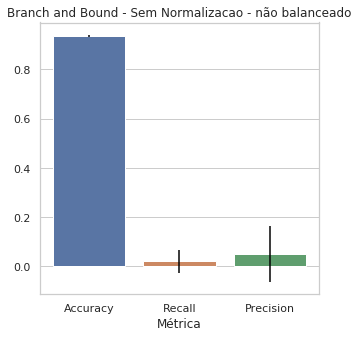

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Branch and Bound - Sem Normalizacao - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Branch_and_Bound-Sem_Normalizacao-nao_balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(157.00000000000003, 0.5, '')]

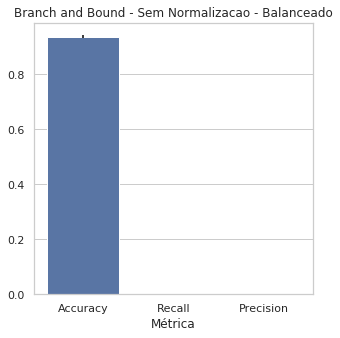

In [25]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Branch and Bound - Sem Normalizacao - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Branch_and_Bound-Sem_Normalizacao-balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [26]:
path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '8',
    'MLPClassifier',
    'Branch and Bound - Sem Normalização - Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    '8',
    'MLPClassifier',
    'Branch and Bound - Sem Normalização - Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value']
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Atividade,Algoritmo,Condicao,Melhores_Params,Metrica,Valor
0,7,SVC,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Accuracy,0.960383
1,7,SVC,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Recall,0.86
2,7,SVC,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Precision,0.677579
3,7,SVC,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.962709
4,7,SVC,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Recall,0.876667
5,7,SVC,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Precision,0.690079
6,7,SVC,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.962709
7,7,SVC,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Recall,0.876667
8,7,SVC,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Precision,0.690079
9,7,SVC,Dataset Completo Balanceado - Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.959193


Resultados salvos com sucesso
